In [1]:
import pandas as pd
import cv2
import torch
import random
import gc
import time
import numpy as np
import sys
import torch.nn as nn
import torch.nn.functional as F
import os
from datetime import datetime
import torchvision
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from transformers import ViTFeatureExtractor, ViTModel
from transformers import AdamW, get_linear_schedule_with_warmup
import math

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
EPOCHS = 25
lr = 2e-5
SEED = 42
BATCH_SIZE = 24
accumulation_steps = 4
seed_everything(SEED)

In [3]:
df = pd.read_csv('../input/caltech256/caltech256.csv')
df.head(2)

Unnamed: 0  fold  label                   path
0           0     1      0  001.ak47/001_0001.jpg
1           1     1      0  001.ak47/001_0002.jpg

In [4]:
valid = df[df['fold']==1].reset_index(drop=True)
train = df[df['fold']!=1].reset_index(drop=True)
print(valid.shape,train.shape)

(6222, 4) (24385, 4)


In [5]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

class CassavaDataset(Dataset):
    def __init__(self, df,transforms=None, output_label=True):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = '../input/caltech256/256_ObjectCategories/256_ObjectCategories'
        self.output_label = output_label
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.df.iloc[index]['label']
          
        path = "{}/{}".format(self.data_root, self.df.iloc[index]['path'])
        
        img  = get_img(path)
        
        if self.transforms:
            img = self.transforms(image=img)['image']
            
        # do label smoothing
        if self.output_label == True:
            return img, target
        else:
            return img

In [6]:
from albumentations import (
    HorizontalFlip, VerticalFlip, Normalize,Resize, Compose
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            Resize(224,224),
            HorizontalFlip(p=0.3),
            VerticalFlip(p=0.3),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            Resize(224,224),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [7]:
valid_ds = CassavaDataset(valid, transforms=get_valid_transforms(), output_label=True)
train_ds = CassavaDataset(train, transforms=get_train_transforms(), output_label=True)

In [8]:
class ArcModule(nn.Module):
    def __init__(self, in_features=768, out_features=151, s = 10, m =0.5):
        super().__init__()
        self.in_features = 768
        self.out_features = 151
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_normal_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = torch.tensor(math.cos(math.pi - m))
        self.mm = torch.tensor(math.sin(math.pi - m) * m)

    def forward(self, inputs, labels):
        cos_th = F.linear(inputs, F.normalize(self.weight))
        cos_th = cos_th.clamp(-1, 1)
        sin_th = torch.sqrt(1.0 - torch.pow(cos_th, 2))
        cos_th_m = cos_th * self.cos_m - sin_th * self.sin_m
        # print(type(cos_th), type(self.th), type(cos_th_m), type(self.mm))
        cos_th_m = torch.where(cos_th > self.th, cos_th_m, cos_th - self.mm)

        cond_v = cos_th - self.th
        cond = cond_v <= 0
        cos_th_m[cond] = (cos_th - self.mm)[cond]

        if labels.dim() == 1:
            labels = labels.unsqueeze(-1)
        onehot = torch.zeros(cos_th.size()).cuda()
        labels = labels.type(torch.LongTensor).cuda()
        onehot.scatter_(1, labels, 1.0)
        outputs = onehot * cos_th_m + (1.0 - onehot) * cos_th
        outputs = outputs * self.s
        return outputs

In [9]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [10]:
class VitModel(nn.Module):
    def __init__(self,latent_dim=512,n_classes=257):
        super(VitModel, self).__init__()
        
        self.classes_ = n_classes
        
        self.vit =  ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.fc_out = nn.Linear(768, latent_dim)
        self.dropout = nn.Dropout(0.2)
        self.margin =  ArcMarginProduct(in_features=512, out_features = self.classes_)
        
    def forward(self, in_data,label=None):
        # Type of output `BaseModelOutputWithPooling`
        vit_outputs = self.vit(in_data)
        
        pooler_output = vit_outputs.pooler_output
        proj= self.fc_out(self.dropout(pooler_output))
        if label:
            out = self.margin(proj,label)
            return {'proj':proj,'label':out}
        else:
            return torch.nn.functional.normalize(proj, p=2.0, dim=1)   ##important for proj normalization

In [11]:
model = VitModel()
model.load_state_dict(torch.load('../input/working-image-search/Vit-Base_224_epoch__15.pth'))
model.cuda()
model.eval()

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VitModel(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=

In [12]:
def valid_func(model,valid_loader):
    model.eval()
    bar = tqdm(valid_loader,file=sys.stdout)
    loss_fn = torch.nn.CrossEntropyLoss()
    PROB = []
    TARGETS = []
    losses = []
    PREDS = []

    with torch.no_grad():
        for batch_idx, (images,labels) in enumerate(bar):
            images = images.cuda()

            logits = model(images)

            PREDS += [logits.detach().cpu()]

    PREDS = torch.cat(PREDS).cpu().numpy()
    return PREDS

In [13]:
train_loader = torch.utils.data.DataLoader(
            train_ds, 
            batch_size=32,
            num_workers=4,
            shuffle=False,
            pin_memory=False,
        )
        
valid_loader = torch.utils.data.DataLoader(
            valid_ds, 
            batch_size=32,
            num_workers=4,
            shuffle=False,
            pin_memory=False,
        )

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
from tqdm.auto import tqdm


candidate_ids = []

for i in tqdm(range(train.shape[0])):
    entry = train['path'][i]+'__'+str(train['label'][i])

    candidate_ids.append(entry)



  0%|          | 0/24385 [00:00<?, ?it/s]

In [15]:
all_train_embeddings = valid_func(model,train_loader)
all_train_embeddings = np.array(all_train_embeddings)
all_train_embeddings = torch.from_numpy(all_train_embeddings)

  0%|          | 0/763 [00:00<?, ?it/s]

# Checking Performance on Seen Image vs Seen Data

In [16]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image,all_candidate_embeddings=all_train_embeddings,top_k=6):
    image = image.cuda()
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(image).cpu()

    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))
 
    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: x.split("__")[0], id_entries))
    labels = list(map(lambda x: int(x.split("__")[-1]), id_entries))
    return ids, labels

In [17]:
import matplotlib.pyplot as plt


def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, img_path) in enumerate(images):
        label_id = int(labels[i])
        img  = get_img(f'{base}/{img_path}')
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(labels[i]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(labels[i])
            )
        plt.imshow(np.array(img).astype("int"))
        plt.axis("off")


In [18]:
def search_random():
    transforms=get_valid_transforms()
    test_idx = np.random.choice(train.shape[0])
    test_path = train['path'][test_idx]
    test_label = train[train['path']==test_path]['label']
    base = '../input/caltech256/256_ObjectCategories/256_ObjectCategories'
    img  = get_img(f'{base}/{test_path}')
    img = transforms(image=img)['image']
    sim_ids, sim_labels = fetch_similar(img.unsqueeze(0))
    
    images = []
    labels = []

    for path, label in zip(sim_ids, sim_labels):
        images.append(path)
        labels.append(label)

    images[1:].insert(0, test_path)  #we are searching the  query image in data containing the query
    labels[1:].insert(0, test_label)
    plot_images(images, labels)
    

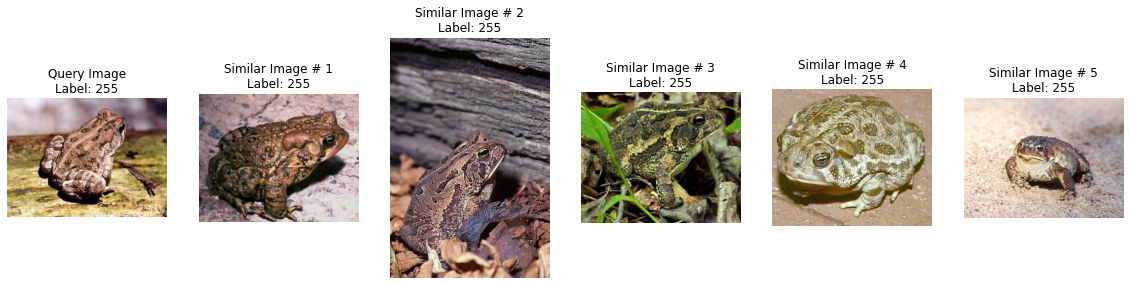

In [19]:
base = '../input/caltech256/256_ObjectCategories/256_ObjectCategories'
search_random()

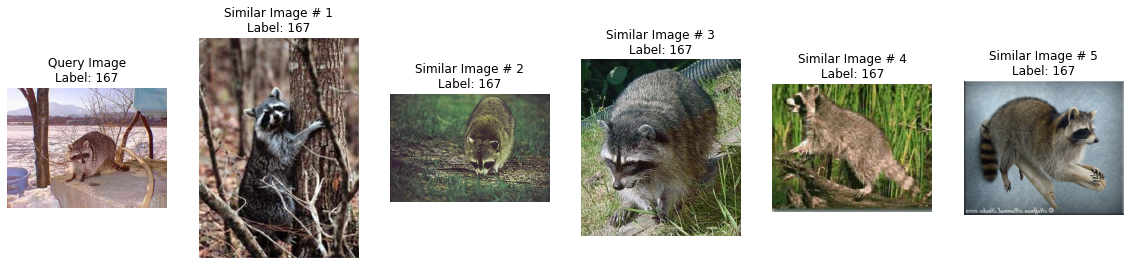

In [20]:
search_random()

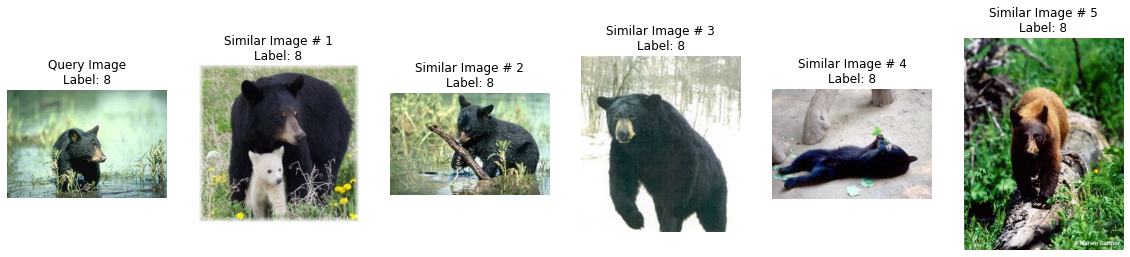

In [21]:
search_random()

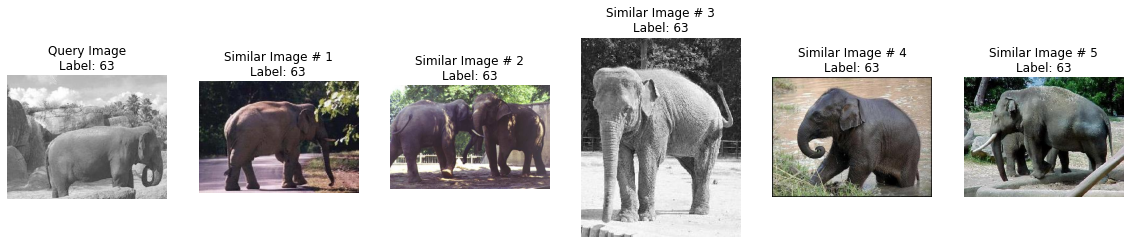

In [22]:
search_random()

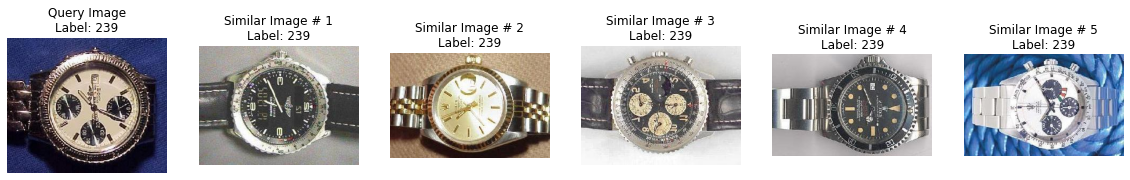

In [23]:
search_random()

# **Checking the performance of the model on Unseen Image Vs Seen Data**

In [24]:
def search_random():
    transforms=get_valid_transforms()
    test_idx = np.random.choice(valid.shape[0])
    test_path = valid['path'][test_idx]
    test_label = valid[valid['path']==test_path]['label']
    base = '../input/caltech256/256_ObjectCategories/256_ObjectCategories'
    img  = get_img(f'{base}/{test_path}')
    img = transforms(image=img)['image']
    sim_ids, sim_labels = fetch_similar(img.unsqueeze(0))
    
    images = []
    labels = []

    for path, label in zip(sim_ids, sim_labels):
        images.append(path)
        labels.append(label)

    images[1:].insert(0, test_path)  #we are searching the  query image in data containing the query
    labels[1:].insert(0, test_label)
    plot_images(images, labels)

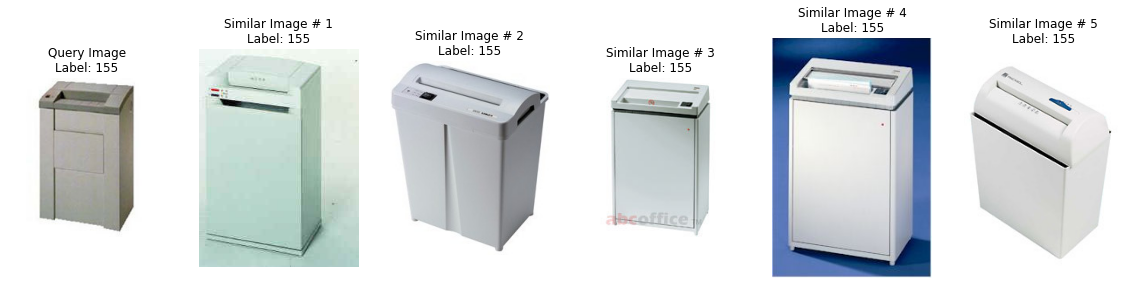

In [25]:
search_random()

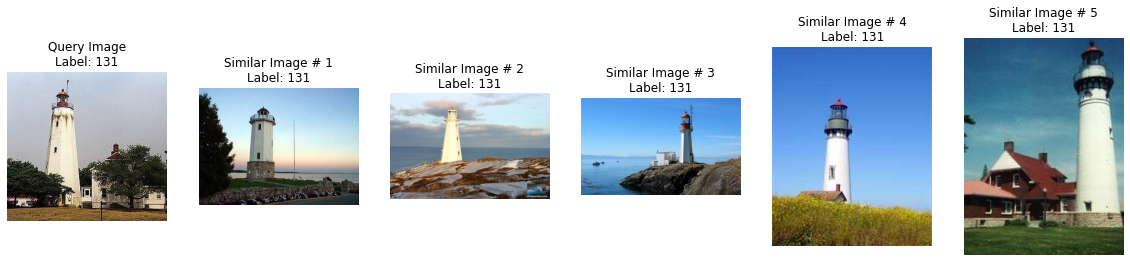

In [26]:
search_random()

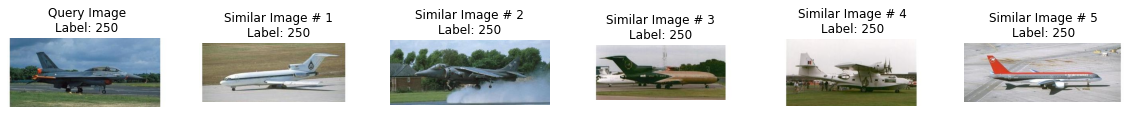

In [27]:
search_random()

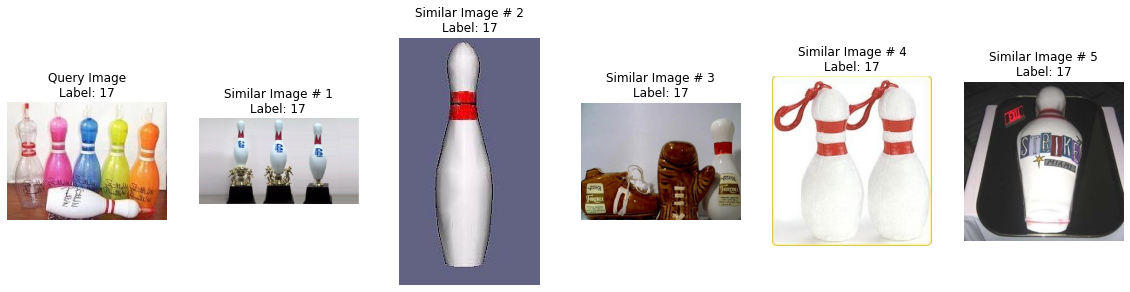

In [28]:
search_random()

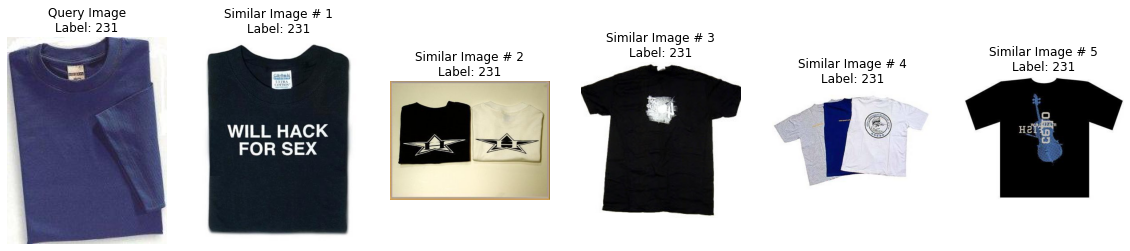

In [29]:
search_random()


# Unseen Image Vs Unssen Data

In [30]:
from tqdm.auto import tqdm


candidate_ids = []

for i in tqdm(range(valid.shape[0])):
    entry = valid['path'][i]+'__'+str(valid['label'][i])

    candidate_ids.append(entry)

  0%|          | 0/6222 [00:00<?, ?it/s]

In [31]:
all_valid_embeddings = valid_func(model,valid_loader)
all_valid_embeddings = np.array(all_valid_embeddings)
all_valid_embeddings = torch.from_numpy(all_valid_embeddings)

  0%|          | 0/195 [00:00<?, ?it/s]

In [32]:
def search_random():
    transforms=get_valid_transforms()
    test_idx = np.random.choice(valid.shape[0])
    test_path = valid['path'][test_idx]
    test_label = valid[valid['path']==test_path]['label']
    base = '../input/caltech256/256_ObjectCategories/256_ObjectCategories'
    img  = get_img(f'{base}/{test_path}')
    img = transforms(image=img)['image']
    sim_ids, sim_labels = fetch_similar(img.unsqueeze(0),all_valid_embeddings)
    
    images = []
    labels = []

    for path, label in zip(sim_ids, sim_labels):
        images.append(path)
        labels.append(label)

    images[1:].insert(0, test_path)  #we are searching the  query image in data containing the query
    labels[1:].insert(0, test_label)
    plot_images(images, labels)

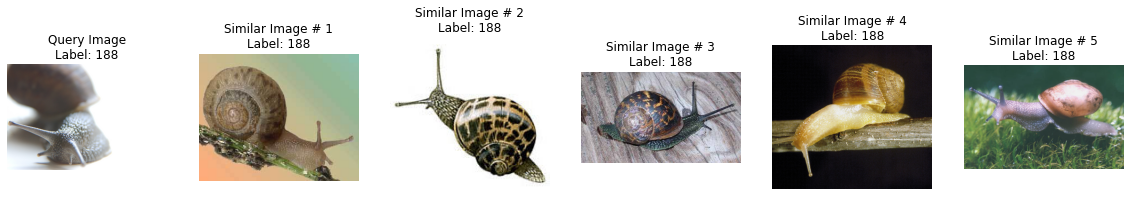

In [33]:
 search_random()

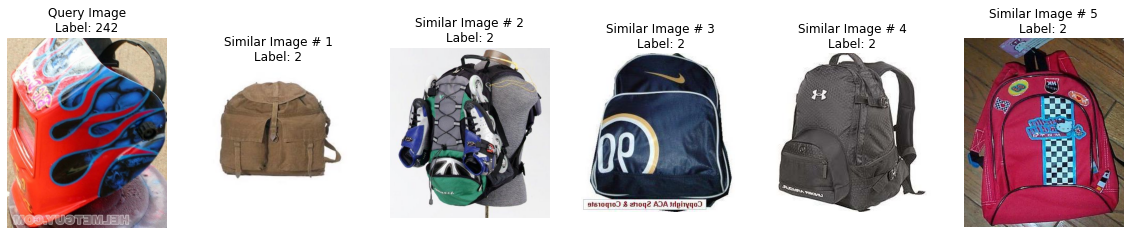

In [34]:
 search_random()

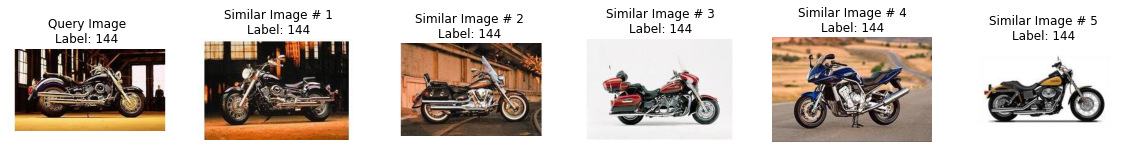

In [35]:
 search_random()

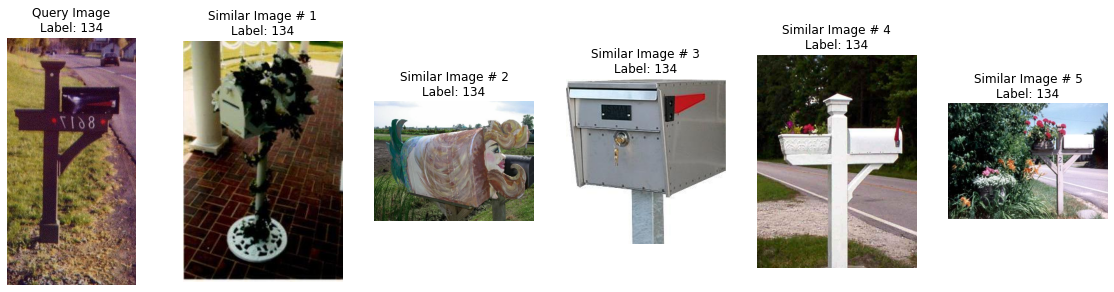

In [36]:
 search_random()

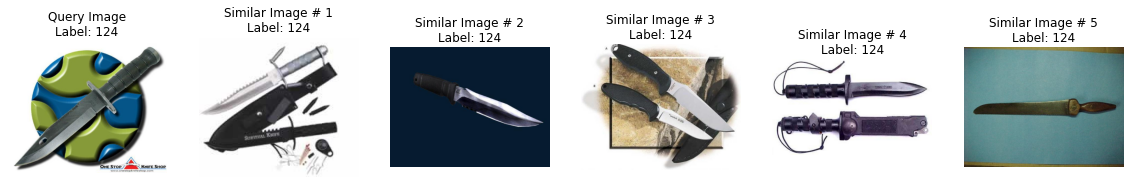

In [37]:
 search_random()

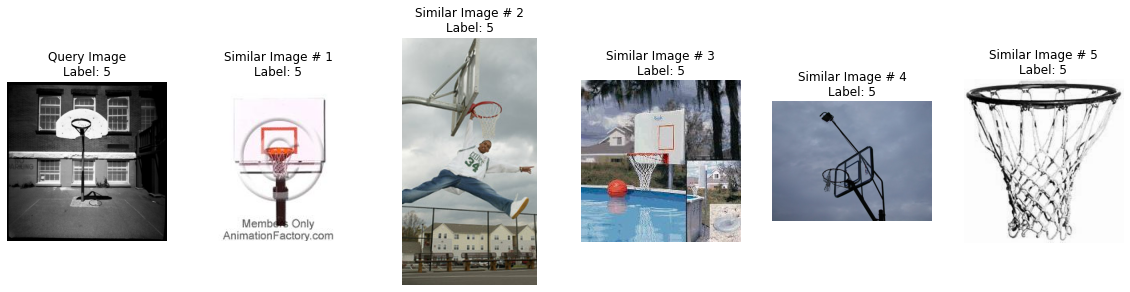

In [38]:
 search_random()

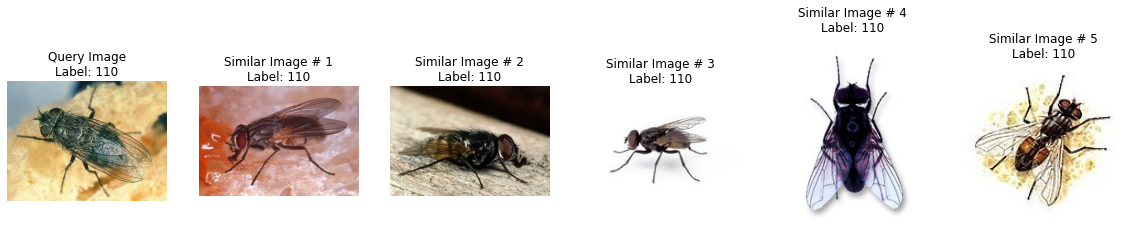

In [39]:
 search_random()

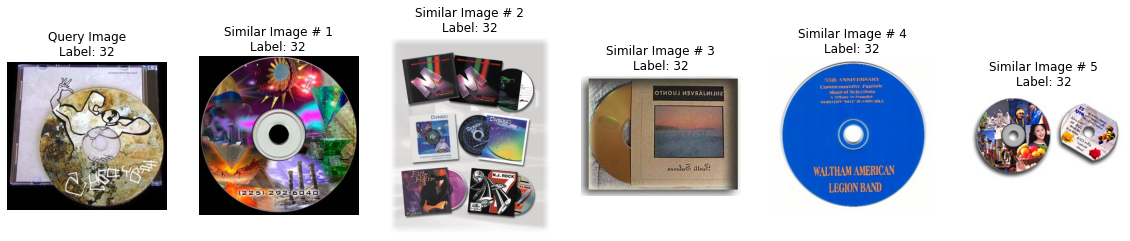

In [40]:
 search_random()

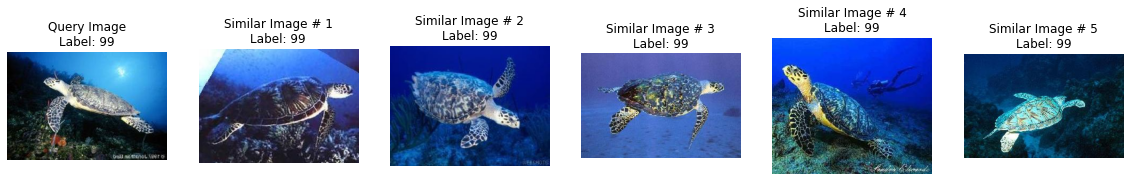

In [41]:
 search_random()

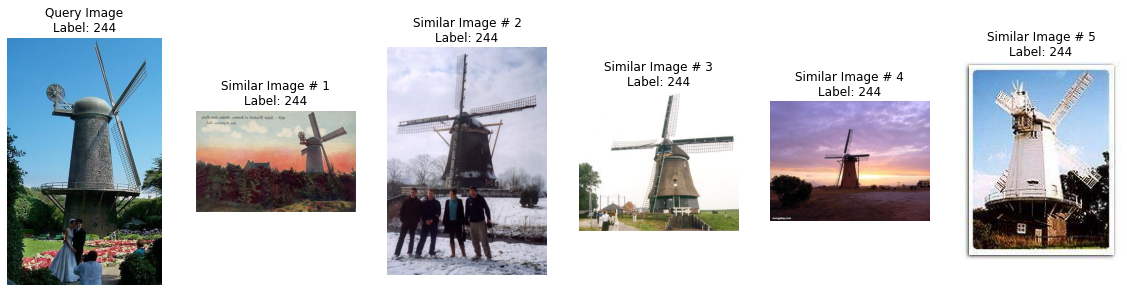

In [42]:
 search_random()

# Cool right!

**If we store the embeddings as is, the memory requirements can shoot up quickly, especially when dealing with millions of candidate images. However, the embeddings are 512-d in our case, which can still be relatively high in the large-scale regime. They have high-dimensional embeddings that directly affect the subsequent computations involved in the retrieval part. So, if we can somehow reduce the dimensionality of the embeddings without disturbing their meaning, we can still maintain a good trade-off between speed and retrieval quality.
So, in the following sections, we'll implement the hashing utilities to optimize the runtime of our image similarity system.**